In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from transformers import GPT2LMHeadModel, AutoTokenizer, GPT2Config
import torch as t 
import matplotlib.pyplot as plt

from hook_handler import HookHandler

In [77]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [78]:
model.to("cuda:3")
tokenizer = AutoTokenizer.from_pretrained('gpt2', return_tensors='pt')

In [5]:
loss_fn = t.nn.functional.cross_entropy

In [68]:
text = """
In a previous post, I discussed a robot whose value system is built to assume the existence of a certain envelope, inside of which is written an algorithm for scoring the “goodness” of a given world. The robot’s objective is to maximize the goodness of its world, as scored by the envelope. Call such a robot an “envelope bot.”
In some situations, this robot is totally screwed. Here’s one. Suppose that Rosie the envelope bot wakes up in a simulation created by Eccentric Ed. Ed’s avatar appears before Rosie and tells her:
“Outside the simulation, back in my office, I have the envelope on my desk. No one has ever opened the envelope, including me, and no one knows what process determined its contents.
Separately, though, I’ve given you a bunch of “evaluative attitudes” – e.g., intuitions about what’s in the envelope, desires to do different things, experiences of different things as “calling to you” or “to be done,” and so on. I chose the content of these by calling up Angela Merkel and asking her what kind of stuff reminds her of apple pie. Turns out Angela has a weird association between apple pie and helium, so you ended up with a set of evaluative attitudes that tend to favor maximizing the amount of simulated helium, albeit in somewhat incoherent ways.
You’ve got about 100 simulated years to live. After that, I’ll bring you out of the simulation, open up the envelope, and tell you how much you improved the world by its lights.”  
My first claim is that Rosie, here, is in a bad way. Why? She has no clue what’s in the envelope.
In particular: her evaluative attitudes aren’t any help. They were determined via a process – namely, by Ed calling up Angela Merkel and asking her about her apple pie associations – that lacks an epistemically relevant connection to the envelope’s contents. Angela’s associating apple pie with helium just isn’t evidence that the envelope’s contents are about helium. And it’s extremely unlikely, on priors, that these contents just happen to be about helium: they could, after all, be about anything.
And note that performing some kind of “idealization” or “reflective equilibrium” procedure on Rosie’s evaluative attitudes doesn’t help. This will just lead to some more coherent version of helium-maximizing. Garbage in, garbage out.
Nor is there some way to figure out the envelope’s contents by “starting from scratch” — ignoring her intuitions, desires, and so forth, and relying on “reason” and “logic” instead (as some utilitarians I meet seem to think they are doing – wrongly, in my opinion). True, reasoning on priors as to what process might’ve fixed the contents of the envelope is better, here, than “seems like helium, probably it’s that.” But it won’t go very far.
Perhaps you reply: “Ah, but doesn’t Rosie have some kind of pro-tanto warrant for trusting her intuitions?” Maybe. But even if so, I don’t think it survives the encounter with Ed’s avatar. The causal origins of her intuitions are, as the epistemologists say, a “defeater.”  
“No they aren’t. It doesn’t matter what her encounter with Ed reveals about the causal origins of her evaluative attitudes. Rosie’s intuitions give her reason to think that the envelope loves helium, so she has reason to think that the causal processes that gave rise to her attitudes happened to lead her to the truth.”
Do you think that in the version of the case where the envelope’s contents were chosen by literally drawing a utility function out of a hat with a trillion utility functions, only one of which was ‘maximize helium’? That feels to me like straightforwardly bad Bayesianism.
“No, but in that case there’s a physical mechanism that mandates that Rosie put a one-in-a-trillion prior on ‘maximize helium,’ lest her credences fail to reflect the objective chances. Absent such a mechanism, though, Rosie is entitled to put a high prior on the envelope loving helium.”
"""
input_ids = tokenizer(text, return_tensors = 'pt').input_ids.to("cuda:3")

In [69]:
input_ids.shape

torch.Size([1, 988])

In [70]:
with HookHandler() as hh:
    hh.add_save_grad_hook(model, "entire_thing")
    logits = model(input_ids).logits
    loss = loss_fn(input=logits[0, :-1], target=input_ids[0, 1:])
    loss.backward()
    grad_input, grad_output = hh.grads["entire_thing"]
    print(grad_input[0].shape, grad_output[0].shape)

torch.Size([988, 50257]) torch.Size([1, 988, 50257])
All hooks removed!


/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:990: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


In [71]:
t.linalg.norm(grad_input[0])

tensor(0.0272, device='cuda:3')

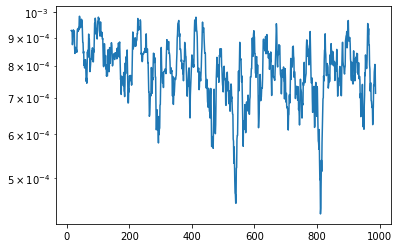

In [74]:
import pandas as pd
import numpy as np
series = pd.Series(np.array(t.linalg.norm(grad_input[0], dim=-1).detach().cpu()))
series.rolling(15).mean().plot()
#series.plot(alpha=.1)
plt.yscale('log')
#plt.xscale('log')

In [33]:
rand_ids = t.randint(low=0, high=tokenizer.vocab_size, size=(1, 900)).to("cuda:3")

/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:990: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


torch.Size([900, 50257]) torch.Size([1, 900, 50257])
All hooks removed!


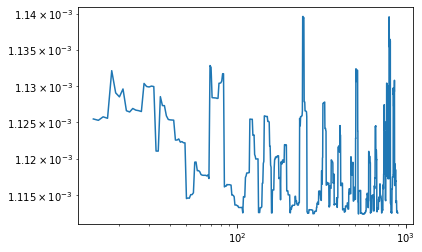

In [62]:
with HookHandler() as hh:
    hh.add_save_grad_hook(model, "entire_thing")
    logits = model(rand_ids).logits
    loss = loss_fn(input=logits[0, :-1], target=rand_ids[0, 1:])
    loss.backward()
    grad_input, grad_output = hh.grads["entire_thing"]
    print(grad_input[0].shape, grad_output[0].shape)

import pandas as pd
import numpy as np
series = pd.Series(np.array(t.linalg.norm(grad_input[0][:-1], dim=-1).detach().cpu()))
series.rolling(15).mean().plot()
#series.plot(alpha=.1)
plt.yscale('log')
plt.xscale('log')

In [79]:
with HookHandler() as hh:
    for i, block in enumerate(model.transformer.h):
        hh.add_save_grad_norm_hook(block, f"block_{i}")
    
    logits = model(input_ids).logits
    loss = loss_fn(input=logits[0, :-1], target=input_ids[0, 1:])
    loss.backward()
    grad_norms = hh.grads


All hooks removed!


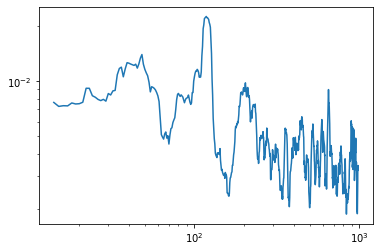

In [81]:
series = pd.Series(np.array(t.sqrt(sum(grad_norms[f"block_{i}"][0]**2 for i in range(12))).cpu()).flatten())
series.rolling(15).mean().plot()
plt.xscale('log')
plt.yscale('log')

In [21]:
untrained = GPT2LMHeadModel(GPT2Config()).to("cuda:3")

In [26]:
tokenizer.decode(t.argmax(untrained(input_ids).logits[0, -1]))

' dissect'

In [75]:
with HookHandler() as hh:
    for i, block in enumerate(untrained.transformer.h):
        hh.add_save_grad_norm_hook(block, f"block_{i}")

    logits = untrained(input_ids).logits
    loss = loss_fn(input=logits[0, :-1], target=input_ids[0, 1:])
    loss.backward()
    grad_norms = hh.grads


All hooks removed!


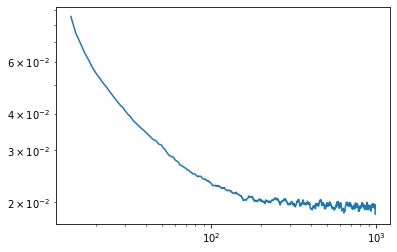

In [76]:
series = pd.Series(np.array(t.sqrt(sum(grad_norms[f"block_{i}"][0]**2 for i in range(12))).cpu()).flatten())
series.rolling(15).mean().plot()
plt.xscale('log')
plt.yscale('log')

All hooks removed!


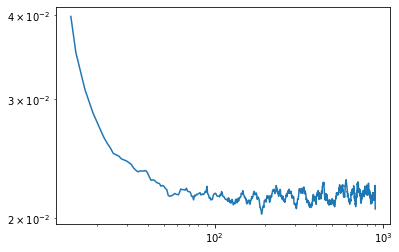

In [44]:
with HookHandler() as hh:
    for i, block in enumerate(untrained.transformer.h):
        hh.add_save_grad_norm_hook(block, f"block_{i}")

    logits = untrained(rand_ids).logits
    loss = loss_fn(input=logits[0, :-1], target=rand_ids[0, 1:])
    loss.backward()
    grad_norms = hh.grads

series = pd.Series(np.array(t.sqrt(sum(grad_norms[f"block_{i}"][0]**2 for i in range(12))).cpu()).flatten())
series.rolling(15).mean().plot()
plt.xscale('log')
plt.yscale('log')